<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/MV_MLP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objective: Predict Monthly Crude Palm Oil Price Using Multilayer Perceptron (MLP)

###Load Libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

###Define Functions to Facilitate Metrics Evaluation

In [39]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [40]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/multivariate-time-series-prediction-of-crude-palm-oil-price-data-science-approach/main/cleaned_data/preprocessed.csv'
df = read_csv(path, index_col=0)
df.head()

,Date,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
0,2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
1,2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2,2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
3,2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
4,2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


In [41]:
df.index = pd.to_datetime(df['Date'], format='%Y.%m.%d')
del df['Date']

In [42]:
df.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


###Plot the Target Variable

Text(0.5, 0, 'Date')

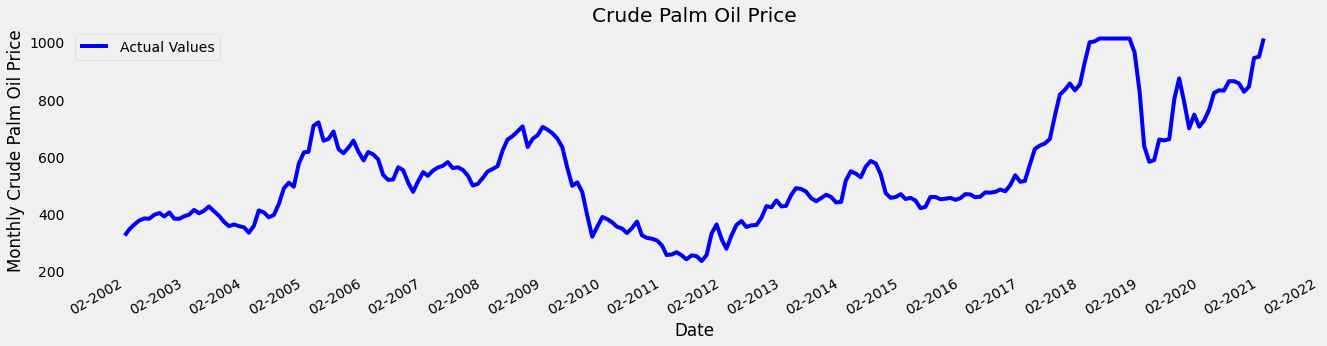

In [43]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(df.index, df['cpo_pri'], color = 'blue',  label = 'Test')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(['Actual Values', 'Crude Palm Oil Price 2002-2021'],loc='best')
plt.title('Crude Palm Oil Price')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')

###Visualize Multiple Time Series

In [44]:
fig = make_subplots(rows=6, cols=1)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['cpo_pri'],name='crude palm oil price'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['cno_pri'],name='coconut oil price'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['rps_pri'],name='rapeseed oil price'),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['pno_pri'],name='peanut oil price'),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['sbo_pri'],name='soybean oil price'),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['wti_spri'],name='west texas intermediate spot price'),
    row=4, col=1

)
fig.update_layout(height=1000, width=1200, title_text="Time Series")
fig.show()

<Figure size 1800x720 with 0 Axes>

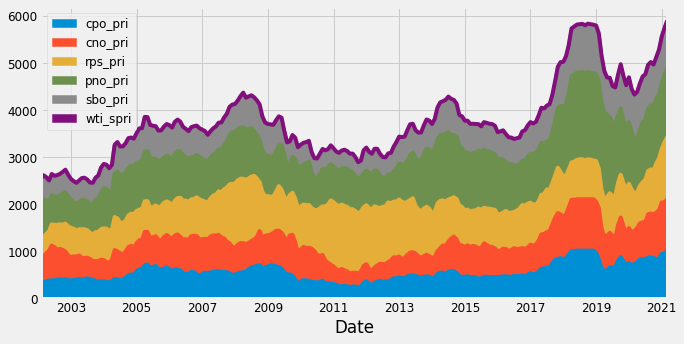

In [45]:
# Plot an area chart
plt.figure(figsize=(25,10))
ax = df.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('Date');
ax.legend(fontsize=12);

##**Multilayer Forecasting Technique (MLP)**

###**Split Data into Train Test Segments**

In [46]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 184
Test size: 46


In [47]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

184 46


In [48]:
print(train.shape)
train.head()

(184, 6)


,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


###Rescale train dataset

In [49]:
#f_transformer = RobustScaler()
f_transformer = MinMaxScaler()
feature_columns = ['cno_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'wti_spri']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,0.288625,0.013238,0.323766,0.432130,0.109026
2002-03-01,345.0,0.443124,0.005303,0.272101,0.472692,0.044200
2002-04-01,362.0,0.526316,0.000000,0.179104,0.427358,0.006514
2002-05-01,376.0,0.595925,0.004228,0.059701,0.370094,0.000000
2002-06-01,383.0,0.769100,0.042041,0.065442,0.339076,0.010236


In [50]:
cpo_pri_transformer = MinMaxScaler()
cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])
train['cpo_pri'].head()

Date
2002-02-01    0.183505
2002-03-01    0.228866
2002-04-01    0.263918
2002-05-01    0.292784
2002-06-01    0.307216
Name: cpo_pri, dtype: float64

In [51]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2017-06-01,638.0,0.757216,0.455910,0.585121,0.979313,0.431141
2017-07-01,645.0,0.811545,0.517005,0.521619,1.021570,0.442463
2017-08-01,661.0,0.821732,0.485027,0.566257,1.031090,0.384150
2017-09-01,743.0,0.921902,0.482428,0.592618,1.113813,0.403381
2017-10-01,816.0,1.033956,0.507880,0.697371,1.197323,0.345068


In [52]:
test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
test['cpo_pri'].head()

Date
2017-06-01    0.832990
2017-07-01    0.847423
2017-08-01    0.880412
2017-09-01    1.049485
2017-10-01    1.200000
Name: cpo_pri, dtype: float64

###Create X_train, y_train, X_test and y_test

In [53]:
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 3
X_train, y_train = createDataset(train, train.cpo_pri, time_steps)
X_test, y_test = createDataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(181, 3, 6) (181,)


In [54]:
X_train_mlp = X_train[:, :, 0]
X_test_mlp = X_test[:, :, 0]
mlp_model = tf.keras.Sequential()
mlp_model.add(tf.keras.layers.Dense(128, input_dim=X_train.shape[1], activation='relu'))
mlp_model.add(tf.keras.layers.Dense(1))

###Compile the model

In [55]:
mlp_model.compile(loss='mse', optimizer='adam')
mlp_model

###Train the model

In [56]:
mlp_history = mlp_model.fit(
    X_train_mlp, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/100
6/6 [==============================] - 1s 28ms/step - loss: 0.3136 - val_loss: 0.2201
Epoch 2/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1967 - val_loss: 0.1262
Epoch 3/100
6/6 [==============================] - 0s 7ms/step - loss: 0.1112 - val_loss: 0.0625
Epoch 4/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0560 - val_loss: 0.0257
Epoch 5/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0265 - val_loss: 0.0088
Epoch 6/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0152 - val_loss: 0.0042
Epoch 7/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0136 - val_loss: 0.0045
Epoch 8/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0144 - val_loss: 0.0048
Epoch 9/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0141 - val_loss: 0.0043
Epoch 10/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0130 - val_loss: 0.0039
Epoch 11/100
6/6 [=========

dict_keys(['loss', 'val_loss'])


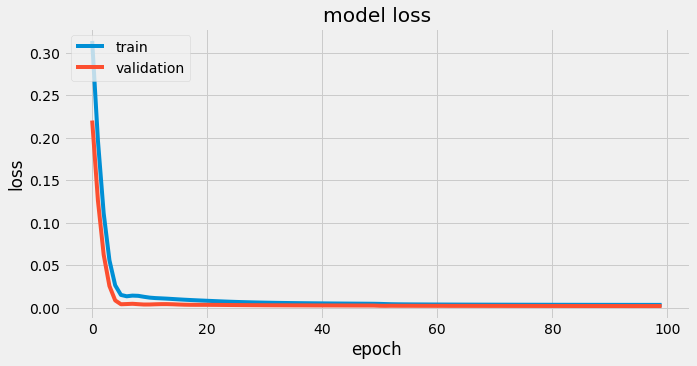

In [57]:
print(mlp_history.history.keys())
plt.plot(mlp_history.history['loss'])
plt.plot(mlp_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

The preceding graph shows that the MLP neural network trained successfully because the two losses are always reducing. Let's use our model to forecast the test data, then scale the output data back to the original values and plot our real and projected data in the same plot to assess how effective our model is.

###Model Summary

In [58]:
mlp_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               512       
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


###Predict the test data

In [59]:
y_pred = mlp_model.predict(X_test_mlp)
y_pred

array([[0.86815226],
       [1.0299889 ],
       [1.142978  ],
       [1.1898003 ],
       [1.2482414 ],
       [1.1999812 ],
       [1.2479258 ],
       [1.3750418 ],
       [1.4894185 ],
       [1.5115848 ],
       [1.550667  ],
       [1.5496914 ],
       [1.552629  ],
       [1.552629  ],
       [1.552629  ],
       [1.552629  ],
       [1.552629  ],
       [1.4589162 ],
       [1.18547   ],
       [0.83675116],
       [0.6946365 ],
       [0.7194228 ],
       [0.87047803],
       [0.8531451 ],
       [0.864488  ],
       [1.1242434 ],
       [1.206424  ],
       [1.1088945 ],
       [0.9269092 ],
       [1.0418216 ],
       [0.94566596],
       [0.9962982 ],
       [1.0708343 ],
       [1.1753862 ],
       [1.1920059 ],
       [1.2004818 ],
       [1.266665  ],
       [1.261112  ],
       [1.2496885 ],
       [1.1904194 ],
       [1.2323265 ],
       [1.4013758 ],
       [1.4019723 ]], dtype=float32)

###Inverse transformed data

Scale the data back to the original representation

In [60]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_pred.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370. 354. 348.
  332. 349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254.
  251. 234. 255. 330. 362. 310. 277. 323. 360. 374. 353. 359. 360. 385.
  426. 422. 446. 425. 427. 465. 489. 486. 477. 454. 443. 454. 466. 458.
  439. 441. 515. 548. 540. 527. 564. 584. 575. 537. 471. 455. 458. 468.
  451. 455. 446. 419. 423. 458. 458. 450. 452. 455. 448. 454. 468. 467.
  457. 459. 474. 473. 476. 484. 478. 499. 534. 511. 514. 572. 626.]]
[[ 743.    816.    833.    855.    831.    852.    926.    999.   1

###Plot history, actual and predicted value

In [61]:
y_train_inv = y_train_inv.flatten()
y_train_inv
y_test_inv = y_test_inv.flatten()
y_test_inv

array([ 743.  ,  816.  ,  833.  ,  855.  ,  831.  ,  852.  ,  926.  ,
        999.  , 1002.  , 1012.25, 1012.25, 1012.25, 1012.25, 1012.25,
       1012.25, 1012.25,  964.  ,  826.  ,  636.  ,  581.  ,  587.  ,
        659.  ,  656.  ,  660.  ,  800.  ,  873.  ,  789.  ,  698.  ,
        746.  ,  704.  ,  725.  ,  763.  ,  822.  ,  831.  ,  830.  ,
        863.  ,  863.  ,  855.  ,  826.  ,  844.  ,  944.  ,  949.  ,
       1012.25])

In [62]:
y_pred_inv = y_pred_inv.flatten()
y_pred_inv

array([655.05383, 733.5446 , 788.3443 , 811.0531 , 839.3971 , 815.9909 ,
       839.24396, 900.89526, 956.368  , 967.1186 , 986.07355, 985.6004 ,
       987.0251 , 987.0251 , 987.0251 , 987.0251 , 987.0251 , 941.57434,
       808.95294, 639.82434, 570.89874, 582.92004, 656.1818 , 647.7754 ,
       653.2767 , 779.25806, 819.1156 , 771.8138 , 683.55096, 739.28345,
       692.64795, 717.2046 , 753.3546 , 804.0623 , 812.12286, 816.23364,
       848.3325 , 845.6393 , 840.09894, 811.3534 , 831.67834, 913.66724,
       913.95654], dtype=float32)

###Plot of Actual and Prediction

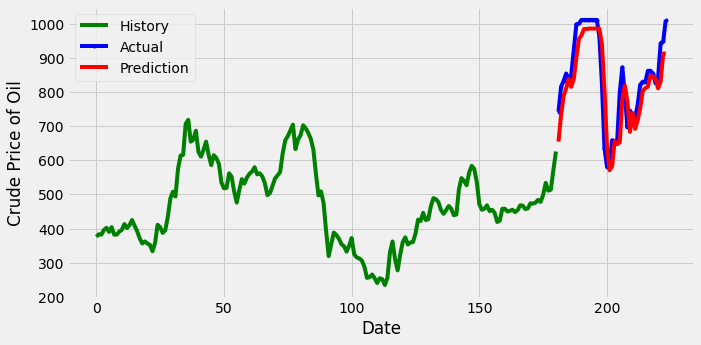

In [63]:
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='red', label="Prediction")
plt.ylabel('Crude Price of Oil')
plt.xlabel('Date')
plt.legend()
plt.show();

###Plot actual and predicted value Zoomed-In

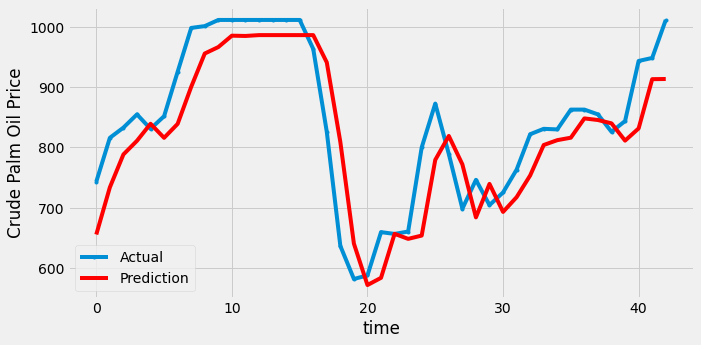

In [64]:
plt.plot(y_test_inv, marker='.', label="Actual")
plt.plot(y_pred_inv, color='red', label="Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('time')
plt.legend()
plt.show();

###Evaluate MLP Model Accuracy

In [65]:
MAE_mlp = mean_absolute_error(y_test_inv, y_pred_inv)
print('MAE value of the SVR Model is:', MAE_mlp)

MDA_mlp = mda(y_test_inv, y_pred_inv)
print('MDA value of the SVR Model is:', MDA_mlp)

MAPE_mlp = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print('MAPE value of the SVR Model is:', MAPE_mlp)

RMSE_mlp = mean_squared_error(y_test_inv,y_pred_inv, squared=False)
print('RMSE value of the SVR Model is:', RMSE_mlp)

MSE_mlp = mean_squared_error(y_test_inv,y_pred_inv)
print('MSE value of the SVR Model is:', MSE_mlp)

EVS_mlp = explained_variance_score(y_test_inv, y_pred_inv)
print('EVS score of the MLP Model is:', EVS_mlp)

MAE value of the SVR Model is: 51.27784622547238
MDA value of the SVR Model is: 0.6190476190476191
MAPE value of the SVR Model is: 6.305091253572788
RMSE value of the SVR Model is: 64.06606455658176
MSE value of the SVR Model is: 4104.460627768102
EVS score of the MLP Model is: 0.7881436397823829
